<a href="https://colab.research.google.com/github/ruchikasi/sbcap/blob/master/Invisalign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Data

This part of the notebook fetches the data from the Invisalign subreddit. 

## Defining functions

We define several functions that allows us to download and parse reddit data. 

In [0]:
!pip install praw 
!pip install sklearn 

import praw 
import pandas as pd
from google.colab import files
from IPython.display import display, clear_output 
import warnings

CLIENT_ID = 'joshs account'
SECRET_ID = 'joshs account'
PW = 'joshs account'
USERNAME = 'joshs account'
reddit = praw.Reddit(
                     client_id=CLIENT_ID,
                     client_secret= SECRET_ID,
                     password=PW,
                     user_agent='testscript by /u/BotanyInTheUk',
                     username=USERNAME
                     )



def get_data(subreddit, nposts, comment_depth):
  """ 
  Get post data for `nposts` of `subreddit`, parsing all comments
  up to depth level `comment_depth`. 
  """
  cofig()
  sample = generate_posts(subreddit, nposts)
  post_data = parse_submissions(sample, comment_data)
  df = pd.DataFrame(post_data)
  return df 

def generate_posts(subreddit, nposts):
  """
  Generate a sample of `nposts` from `subreddit. 
  
  Params:
    subreddit (str): The subreddit
    nposts (int): The number of posts 
  Returns :
    A list of PRAW objects
  """
  sample = []
  sub = reddit.subreddit(subreddit)
  top_sub = sub.top(limit=nposts)
  for post in top_sub:
    if post not in sample:
      sample.append(post)
    print(len(sample))
  return sample
  
def parse_submissions(submissions, comment_limit):
  """
  Returns a list of parsed submissions.
  
  Params:
    submissions (list): A list of PRAW objects 
    comment_limit (int): Determines depth of comment tree 
  Returns:
    A list of dicts, each dict being the info for a post
  """
  submission_count = 0
  all_post_data = []
  added_posts = []
  for post in submissions:
    if not(already_added(added_posts, post.title)):
      post_data = get_post_data(post, comment_limit)
      all_post_data.append(post_data)
      submission_count+=1
      print("POST {} OF MAX: {}".format(submission_count, len(submissions)))
  return all_post_data


def get_post_comments(post, comment_limit):
  """Returns comments of post of level <= comment_limit."""
  comments = []
  post.comments.replace_more(limit=2)
  for comment in post.comments.list():
    comments.append(comment.body)
  comment_str = " ".join(comments)
  return comment_str

def get_post_data(post, comment_limit):
  """Parses a post to return data in a dict format"""
  post_info = {
    "title": post.title,
    "flair": post.link_flair_text	,
    "post_id": post.id,
    "timestamp":post.created_utc,
    'selftext' : post.selftext,
    "score": post.score,
    "upvote_ratio": post.upvote_ratio,
    "num_comments" : post.num_comments,
    "comments": get_post_comments(post, comment_limit)
  }
  return post_info

def already_added(list_to_check, item):
  """Check if item added to list. If not, add item to list."""
  if item in list_to_check:
    return True
  else: 
    list_to_check.append(item)
    return False
  
def config():
  """ Ignore warnings, clear output"""
  warnings.filterwarnings("ignore", category=DeprecationWarning)
  clear_output()

## Making function call

Now we actually get the data. 

In [0]:
subreddit = 'invisalign'
nposts = 1000
comment_depth = 2
data = get_data(subreddit, nposts, comment_depth)
data.to_json("invis.json")
files.download("invis.json")

# Analysis






## Install packages

Install dependencies for analysis



In [0]:
!pip install nltk
!pip install eli5 

# Utilities 
import re
import string 
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import random

# NLP Libraries 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# Quant libraries 
import eli5
from sklearn.linear_model import LinearRegression
import seaborn as sns 
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
clear_output()

## Explore DataFrame

In [0]:
# upload file 
from google.colab import files
files.upload()

In [0]:
# Read in json
df = pd.read_json("invis.json")

# Examine structure
print("Head", df.head(5))
print("Tail", df.tail(5))
print("Length", len(df))

# Take a look at columns 
print(df.dtypes, "\n")

# Check for null values in columns
null_columns = df.columns[df.isnull().any()]
print(df[null_columns].isnull().sum())


# The timestamp is a unix variable, so 
# It's better to turn this into something more interesting. 
def parse_date(df):
  df['date'] = pd.to_datetime(df['timestamp'],unit='s')
  df['year'] = pd.DatetimeIndex(df['date']).year  
  df['month'] = pd.DatetimeIndex(df['date']).month
  df['day'] = pd.DatetimeIndex(df['date']).dayofweek
  df['hour'] = pd.DatetimeIndex(df['date']).hour
  return df 

df = parse_date(df)


Head                                               comments  ...  upvote_ratio
0    I have been a long time lurker on this sub sin...  ...          0.99
1    Beautiful! I love seeing these posts, they are...  ...          1.00
10   Awesome progress!\n\nHopefully you don’t need ...  ...          1.00
100  i can’t believe the change in face shape! and ...  ...          1.00
101  Oh fuck I gotta put mine back in  I'm a year i...  ...          0.96

[5 rows x 9 columns]
Tail                                               comments  ...  upvote_ratio
993  I had a filling done on tray 8 of 16. I was wo...  ...          0.93
994  Good luck! Only trays and no elastics? Yay! I ...  ...          1.00
995  Congrats! I’m starting in 3 weeks and I also h...  ...          0.93
996  That's great! My orthodontist also said I will...  ...          0.94
997  I’ve chewed on the other end of my toothbrush....  ...          1.00

[5 rows x 9 columns]
Length 998
comments                object
flair           

So we know that there is no flair for this subreddit

# Explore quantitative variables

## Let's look at some features. 

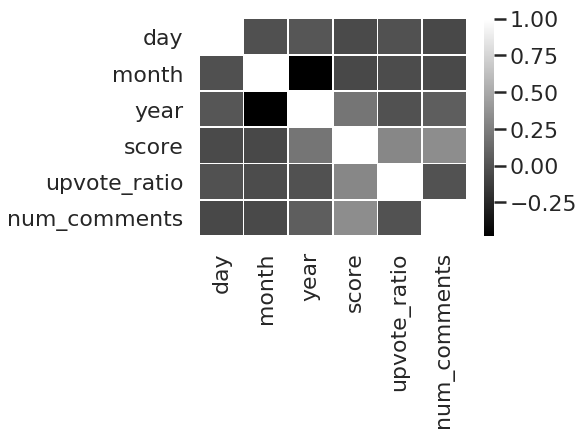

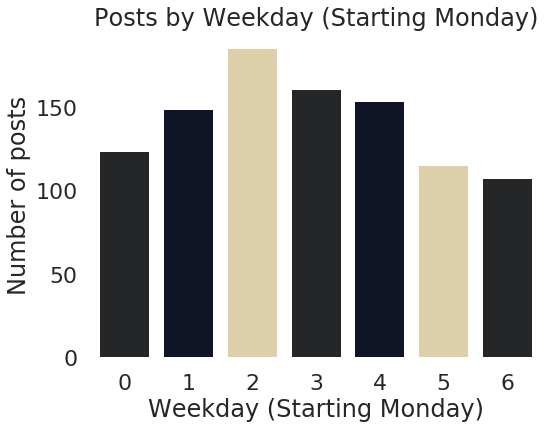

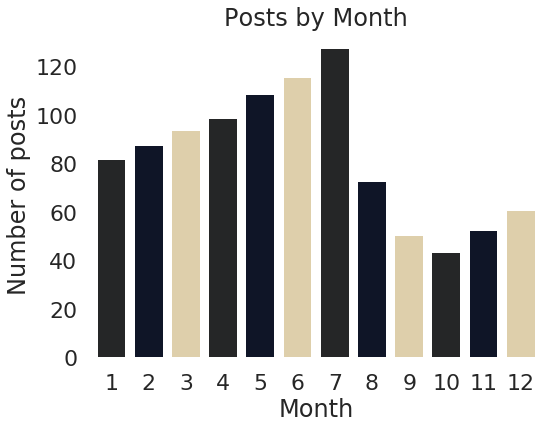

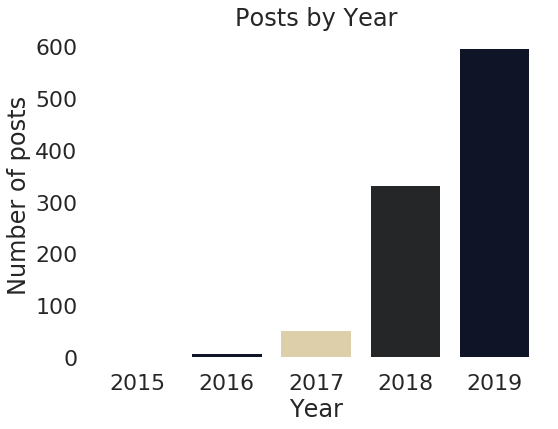

count    998.000000
mean       0.969770
std        0.037663
min        0.770000
25%        0.950000
50%        0.980000
75%        1.000000
max        1.000000
Name: upvote_ratio, dtype: float64


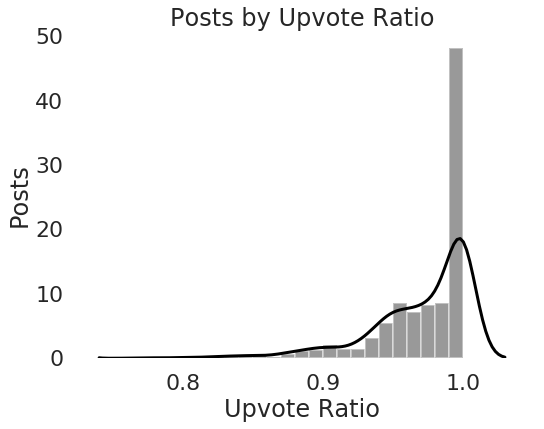

count    998.000000
mean      49.035070
std       46.544677
min       10.000000
25%       18.000000
50%       32.000000
75%       63.000000
max      460.000000
Name: score, dtype: float64


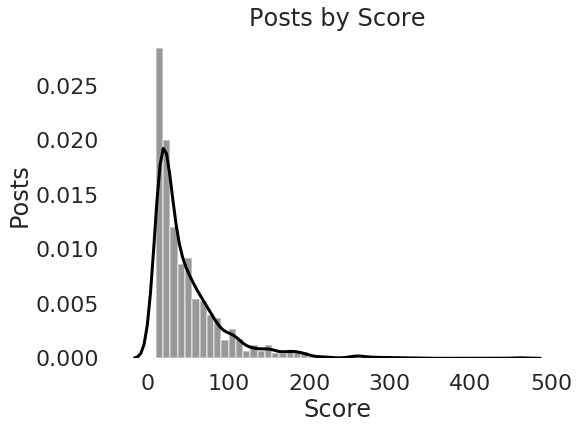

In [0]:
  # Countplot
def countplot(df, var, label):

  # Style settings and filename
  config_graph()
  plt.figure(figsize=(8,6))
  filename = "{}{}.png".format("count", label)

  # Make plot 
  plot = sns.countplot(x=var, data=df, palette=my_colors)
  
  # Despine 
  sns.despine(left=True, bottom=True, top=True, right=True)
  
  #  Label
  plt.xlabel(label)
  plt.ylabel("Number of posts")
  plt.title("Posts by {}".format(label))
  plt.show()
  plt.close("all")
  
  # Distplot
def distplot(df, var, label): 
  
  # Style settings and filename
  sns.set(style="white")
  sns.set_context("poster")
  plt.figure(figsize=(8,6))
  
  # Make plot
  plot = sns.distplot(df[var], color="Black")
  
  # Despine 
  sns.despine(left=True, bottom=True, top=True, right=True)
  
  # Label 
  plt.xlabel(label)
  plt.ylabel("Posts")
  plt.title("Posts by {}".format(label))
  plt.show()
  plt.close("all")
  
 # Heatmap
def heatmap(df, columns):
  
  # Style settings
  sns.set(style="white")
  sns.set_context("poster")
  data = df[columns]
  cor = data.corr()
  sns.heatmap(cor, 
              cmap='binary_r', 
              linewidths=0.7, 
              robust=True
             )
  
#####################################

 # Make heatmap
cor_cols = [
                'day', 
                'month', 
                'year', 
                'score', 
                'upvote_ratio', 
                'num_comments'
]
heatmap(df, cor_cols)

 # Make countplots 
countplot_labels = {
          'day': 'Weekday (Starting Monday)', 
          'month':'Month', 
          'year':'Year',
}
for var in countplot_labels:
  countplot(df, var, countplot_labels[var])
 

 # Make distplots
distplot_labels = {
          'upvote_ratio': 'Upvote Ratio', 
          'score':'Score'
}
for var in distplot_labels:
  print(df[var].describe())
  distplot(df, var, distplot_labels[var])

# NLP

## Defining Functions
There are two sets of important functions in this notebook. One set cleans a document. The other analyzes the document. 

###  Cleaning **text**

In [0]:
def preprocess(docs, settings):
  """ 
  Clean and tokenize text document
  """
  clean_docs = [clean_text(i, settings) for i in docs]
  clean_docs = [tokenize(i, settings) for i in clean_docs]

  return clean_docs

def tokenize(text, settings):
  """ 
  Tokenizes text -- returning the tokens as a string 
  """
  nltk_tokenizer = nltk.WordPunctTokenizer().tokenize
  lemmatizer = WordNetLemmatizer()

  tokens = nltk_tokenizer(text)  
  lemmas = [lemmatizer.lemmatize(token) for token in tokens]
  result =  [i for i in lemmas if len(i)>settings['min_len']]
  result = " ".join(result)
  
  return result

def clean_text(text, settings): 
  """ 
  Cleans text -- 
  
  Removes case, removes punctuation,
  removes stopwords, and removes numbers (if specified. 
  """
  new_text = make_lowercase(text)
  new_text = remove_punct(new_text)
  if settings['keep_numbers'] is False: 
    new_text = remove_numbers(new_text)
  new_text = remove_stopwords(new_text, settings)
  return new_text

def make_lowercase(text):
  new_text = text.lower()
  return new_text

def remove_numbers(text):
  new_text = ''.join([i for i in text if not i.isdigit()])
  return new_text

def remove_stopwords(text, settings):
  stop_words = set(stopwords.words("english")).union(settings['custom_stopwords'])
  new_text = ' '.join([i for i in text.split() if not i in stop_words])
  return new_text

def remove_punct(text: str) -> str:
    for p in string.punctuation:
        text = text.replace(p, '')
    return text

### Analyzing topics

This set of functions is the core of this notebook's analysis. We'll generate topics and some data on topic distributions. One thing I find really helpful is to also show representative documents for each topic. So we'll have a sense of what each topic looks like, in the wild. 



In [0]:
def print_topic_dist(W, labels=None, title=None):
  """
  Creates graph of NMF topic distribution.

  NOTE:  NMF actually assumes that each document is a linear combination of topics. 
  Here, we will just say each document's 'topic' is the topic for which it has the 
  highest weight. So when presenting these results, be sure to say "X% of Things were *primarily*
  about Y", where the "primarily" modifer is the human way of saying we took the argmax.  

  For a more in-depth analysis, we'd cluster on the topic weights. 
  """
  
  topics = pd.DataFrame(W).idxmax(axis=1, skipna=True).tolist()
  dfW = pd.DataFrame(topics, columns=['topic'])
  dfW.sort_values("topic", inplace=True)
  
  # Topic percentages
  topic_percentages = dfW['topic'].value_counts(normalize=True)
  print(topic_percentages)
    
  # Plot settings 
  sns.set(style="white")
  sns.set_context("poster")
  plt.figure(figsize=(8,6))
  filename = "NMF"
  
  # Make plot with labels 
  a = sns.countplot(y='topic', data=dfW, palette= my_colors)
  if labels:
    a.set_yticklabels(labels)
  a.set(xlabel="Number of Posts")
  a.set(ylabel="Topic")
  if title:
    plt.title(title)

  sns.despine(left=True, bottom=True, top=True, right=True)
  plt.show()
  plt.close()
  return df

  
def display_topics(H, W, feature_names, df, no_top_words, no_top_documents):
  """ 
  Provides info on topic model by printing words 
  associated with topic and representative documents. 
  """
  for topic_idx, topic in enumerate(H):
      print ("Topic {}: ".format(topic_idx)  + ",".join(
          [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
      top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
      for idx in top_doc_indices:
          print (df['comments'].tolist()[idx][:150])
      print()
      
# Build a topic analysis model 
def make_topics(df, clean_docs, settings):
  """ 
  Build a topic analysis model - 
  
  Using a TF-IDF vectorizer and an NMF model
  for dimensionality reduction. 
  """
  no_topics = settings['n_topics'] # hypothesized latent topics 
  no_top_words = settings['n_top_words'] # number of sample words per topic 
  no_top_documents = settings['n_top_docs'] # number of docs to print per topic 
  ngram = settings['ngram']
  max_df = settings['max_df']
  
  # Fit a TFIDF vectorizer 
  tfidf_vectorizer = TfidfVectorizer(
                                     max_df=max_df,
                                     min_df = 2,
                                     stop_words='english', 
                                     ngram_range = (ngram[0], ngram[1])
  )
  
  tfidf = tfidf_vectorizer.fit_transform(clean_docs)
  tfidf_feature_names = tfidf_vectorizer.get_feature_names()

  # Run NMF
  nmf_model = NMF(n_components=no_topics,
                  random_state=1, 
                  alpha=0.000001, 
                  init='nndsvd').fit(tfidf)
  
  nmf_W = nmf_model.transform(tfidf)
  nmf_H = nmf_model.components_
  
 
  # Display topics 
  display_topics(nmf_H, nmf_W, tfidf_feature_names, df, no_top_words, no_top_documents)
  return nmf_W, nmf_H      
      

## Make topics

Cleaned. 

Topic 0: refinement,bite,treatment,tray,ortho,brace,need
I’ve seen lots of people that had more refinements than original set. Just make sure it’s fixing what you want cause I think you’re right with Lite th
You appear to maybe have an open posterior bite - do the molars and premolars meet? At these angles it doesn't look like it. But the bite needs to clo
You might have 3 crooked *looking* teeth but you could have all sorts of bite issues and such. Rather have it done right than rushed. There are people

Topic 1: look,great,amazing,wow,look great,congrats,thank
I'm on 2 of 26 right now. Here's hoping I can get results similar to yours! Looks great! Wow. One day, that's gonna be me in 39 weeks 😭 That looks ama
Wow. Looking great! Congrats :) They look amazing already!!! Wow what a transformation already! Congrats!  Looks great! Congrats! Looks great already!
I have been a long time lurker on this sub since starting Invisalign in April 2017. You guys have gotten me through th

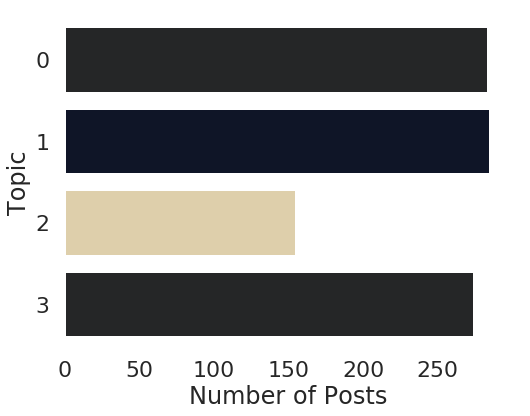

In [0]:
clean_settings = {
         "min_len": 2,
         "keep_numbers": False,
          "custom_stopwords":{
                            'teeth',
                            'invisalign'
  }
}
 
topic_settings = {
                  "n_topics": 4, 
                  "n_top_words": 7, 
                  "max_df": 0.95,
                  "n_top_docs": 3, 
                  "ngram": [1,2]            
}
  
# Get a list of titles  
my_df = df.dropna(subset=['comments'])
documents = my_df['comments'].tolist()
clean_docs = preprocess(documents, clean_settings)
print("Cleaned. \n")

# Build topic model 
W, H = make_topics(df, clean_docs, topic_settings)
dist = print_topic_dist(W)

## Word Analysis

In this section, we will pick a target metric (where applicable) and see which words contribute most to a document's score on this metric. 

Weight?,Feature
+62.274,waiting
+48.406,changing every
+37.262,anyone else
+34.863,actually
+26.230,enough
+25.623,surgery
+23.004,feel
+21.070,going
+20.552,confidence
+19.783,ask


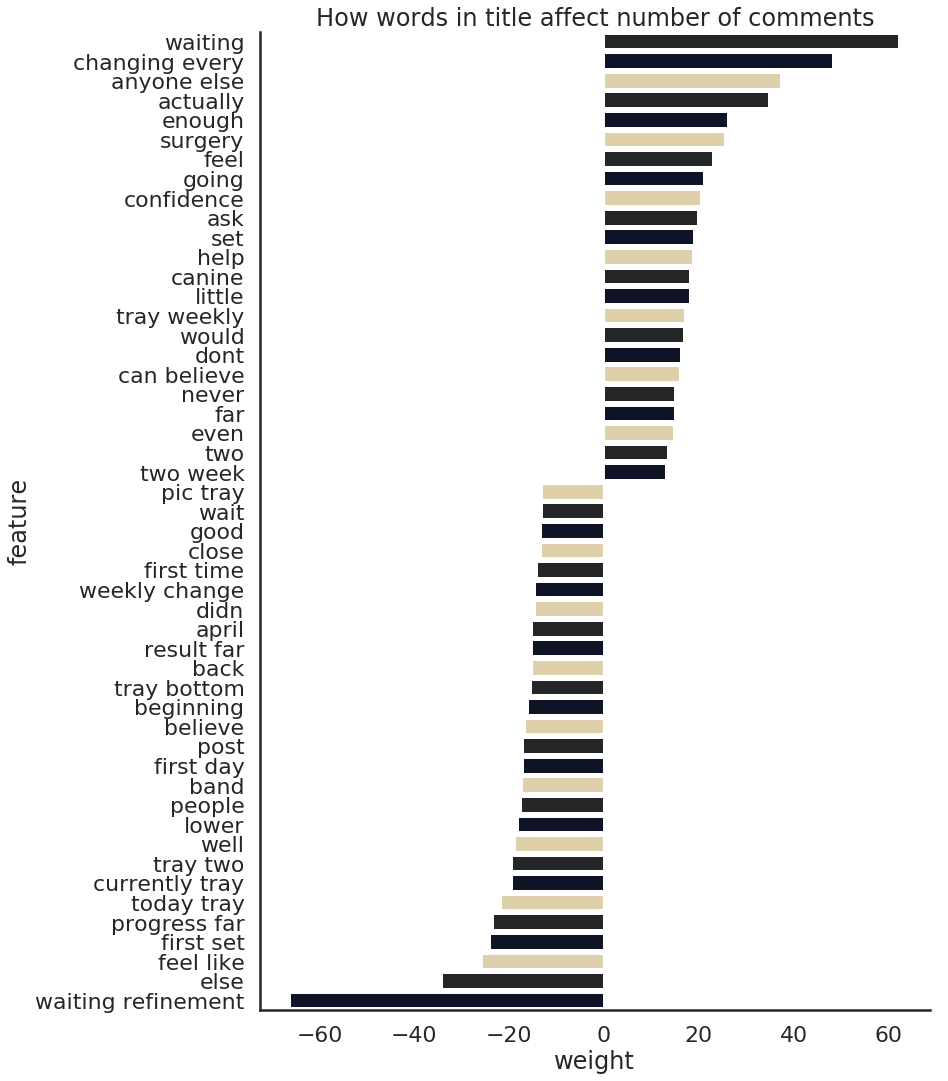

In [0]:
def graph_weights(weights, feature_name, metric_name):
  """Show each word's contribution to a target metric"""
  
  # Plot settings 
  sns.set(style="white")
  sns.set_context("poster")
  plt.figure(figsize=(12,18))

  # Make plot with labels 
  sns.barplot(y='feature', x='weight', data=weights, palette=my_colors)
  sns.despine()
  plt.title("How words in {} affect {}".format(feature_name, metric_name))
  return weights


def find_important_words(df, text_col, target_col, topn, npreds):
  """ See which words are predictive of a particular variable. """
  vectorizer = TfidfVectorizer(
                              analyzer='word',
                              token_pattern=r'\w{1,}',
                              ngram_range=(1, 2),
                              min_df=5, 
                              max_df = 0.95
  )

  # Build a model using text columns as features
  text = preprocess(df[text_col].tolist(), clean_settings)
  text = vectorizer.fit_transform(text)
  linreg = LinearRegression().fit(text, df[target_col])

  
  # Show weights
  display(eli5.show_weights(
                            linreg, 
                            vec=vectorizer, 
                            top=topn, 
                            feature_filter=lambda x: x != '<BIAS>'
          )
         )
  
  # Show some predictions
  for pred in range(npreds):
    obs = random.randint(0, len(df))
    display(eli5.show_prediction(linreg, doc=df[text_col].values[obs], vec=vectorizer))
  
  return eli5.formatters.as_dataframe.explain_weights_df(linreg, 
                                                         vec=vectorizer,
                                                         top=topn, 
                                                         feature_filter=lambda x: x != '<BIAS>')

weights =  find_important_words(df, "title", "num_comments", 50, 10)
weights = graph_weights(weights, "title", "number of comments")